<h1>Part 1 - Preprocessing</h1></br>(This was accomplished in the last deliverable - skip to pt II)

This Notebook is being used as a quick preparation for Modeling. The purpose will be to replace the categorical variable, standardize features using StandardScaler(), and to split the dataframe into training and testing sets.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os.path


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.classifier import ClassificationReport

import warnings
warnings.filterwarnings('ignore')

upon inspection of my dataframe, some index columns had been inserted between all of the notebooks that I have been using. This column is simply removing the unnecessary index columns (including the seq_number id field that I used to merge tables together earlier in the project as it is no longer needed)

In [2]:
df = pd.read_csv('my_data/prep_preprocess.csv')
df.rename(columns={"Unnamed: 0":"delete"},inplace=True)
df = df.drop(columns=["delete","Seq_Number"])

The only Categorical field in the dataframe was the age_grp column that I inserted last notebook to differentiate between rows that represented children (<=18) and adults. This cell is replacing that field with dummy binary fields.

In [3]:
age_grp_dummy = pd.get_dummies(df['age_grp'])
df = pd.concat([df,age_grp_dummy],axis=1).drop(columns=["age_grp"])

In [4]:
df['obese'] = 0
df.loc[df['bmi'] >= 26, 'obese'] = 1

df.loc[df['Gender'] == 1, 'Gender'] = 0
df.loc[df['Gender'] == 2, 'Gender'] = 1

df.head()

,Gender,Age_yr,#_diff_foods,tot_calories,total_protein,total_carb,total_sugar,total_fiber,total_fat,avg_visc_fat,bmi,waist,weight,ave_BP,adult,child,obese
0,0,69,11.0,1574.0,43.63,239.59,176.47,10.8,52.81,20.6,26.7,100.0,78.3,112.666667,1,0,1
1,0,54,8.0,5062.0,338.13,423.78,44.99,16.7,124.29,24.4,28.6,107.6,89.5,157.333333,1,0,1
2,0,72,27.0,1743.0,64.61,224.39,102.90,9.9,65.97,25.6,28.9,109.2,88.9,142.000000,1,0,1
3,0,9,19.0,1490.0,77.75,162.92,80.58,10.6,58.27,14.9,17.1,61.0,32.2,104.666667,0,1,0
4,1,73,7.0,1421.0,55.24,178.20,87.78,12.3,55.36,20.8,19.7,88.6,52.0,137.333333,1,0,0


Then finally we are splitting the data into training and testing sets.

In [5]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["obese", "bmi"])
y = df.obese == 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

We are dropping bmi as it is wildly skewing the results.... this makes sense, since it is what is being used to classify our obese feature.... 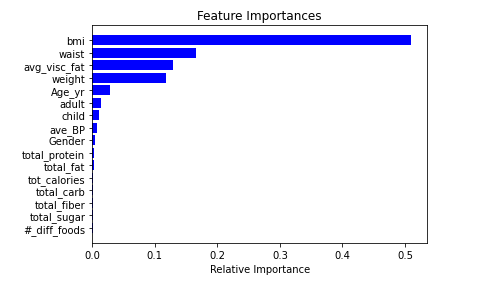

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
'''rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
for name, importance in zip(df.columns, rnd_clf.feature_importances_):
    print(name, "=", importance)

features = df.columns
importances = rnd_clf.feature_importances_
indices = np.argsort(importances)

plt.title ('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()'''

'rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)\nrnd_clf.fit(X_train, y_train)\nfor name, importance in zip(df.columns, rnd_clf.feature_importances_):\n    print(name, "=", importance)\n\nfeatures = df.columns\nimportances = rnd_clf.feature_importances_\nindices = np.argsort(importances)\n\nplt.title (\'Feature Importances\')\nplt.barh(range(len(indices)), importances[indices], color=\'b\', align=\'center\')\nplt.yticks(range(len(indices)), [features[i] for i in indices])\nplt.xlabel(\'Relative Importance\')\nplt.show()'

That concludes the scope of this notebook, later we will Model our standardized data and see what insights we can come up with!

<h1>Part 2 - Modeling</h1>

I originally thought that this was a regression problem, but I have added a Binary field entitled obese, where individuals are given a value of 1 if they have a bmi of 26 or more as this would imply that they are overweight. With this in mind, this now becomes a classification problem and we can employ classification models....

In [8]:
def display_score_results(model):
    visualizer = ClassificationReport(model, classes=[1,0], support=True)

    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show() 
    
    
    cv_scores_test= cross_val_score(model,X_test,y_test,cv=5,scoring='roc_auc')
    cv_scores_train= cross_val_score(model,X_train,y_train,cv=5,scoring='roc_auc')
    print("5-fold CV Scores: ", cv_scores_test)
    print ('Mean testing score: ', cv_scores_test.mean())
    print ('Mean training score: ', cv_scores_train.mean())
    print ('Standard deviation: ', cv_scores_test.std())

<h2>Random Forest</h2>

[[892  63]
 [ 72 680]]
0.9209138840070299


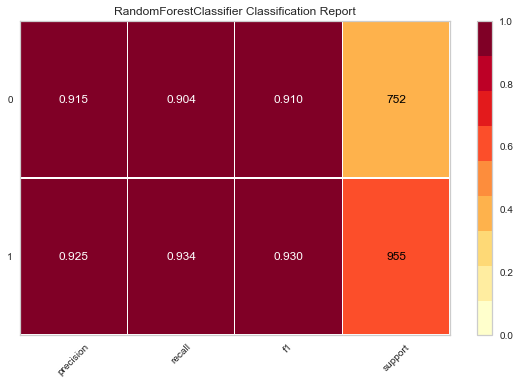

5-fold CV Scores:  [0.98779515 0.98008044 0.98062827 0.97706806 0.97291449]
Mean testing score:  0.9796972828034164
Mean training score:  0.9812822615143816
Standard deviation:  0.004888930158500781


In [9]:
rf = RandomForestClassifier(bootstrap=True,n_estimators=100,criterion='entropy')
rf.fit(X_train, y_train)

y_predict_rf = rf.predict(X_test)

print(confusion_matrix(y_test, y_predict_rf))
print(rf.score(X_test,y_test))
display_score_results(rf)

<h2>K-Nearest Neighbor</h2>

[[875  80]
 [ 85 667]]
0.9033391915641477


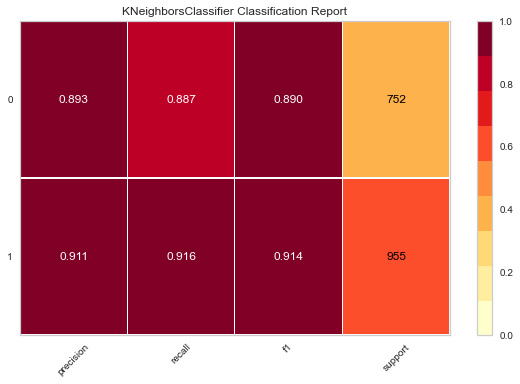

5-fold CV Scores:  [0.96688742 0.95849658 0.96453752 0.96317627 0.94212914]
Mean testing score:  0.9590453867757706
Mean training score:  0.9698870895841584
Standard deviation:  0.008890282002512035


In [10]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(p=2,weights='distance',n_neighbors=50)
knn.fit(X_train,y_train)

y_predict_knn=knn.predict(X_test)

print(confusion_matrix(y_test, y_predict_knn))
print(knn.score(X_test,y_test))
display_score_results(knn)

<h2>Support Vector Machine</h2>

[[911  44]
 [ 70 682]]
0.9332161687170475


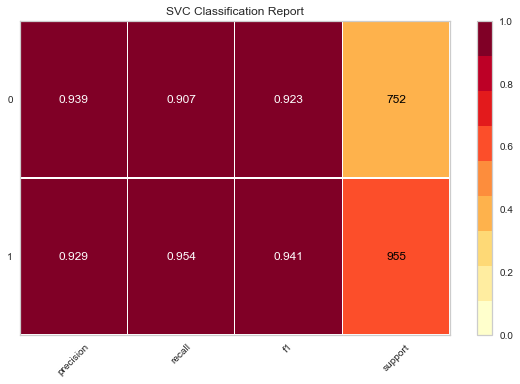

5-fold CV Scores:  [0.98720571 0.98075656 0.98485166 0.98136126 0.9782199 ]
Mean testing score:  0.9824790171399511
Mean training score:  0.9812796525550965
Standard deviation:  0.0031726155886407825


In [11]:
from sklearn.svm import SVC

svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

y_predict_svm=svm.predict(X_test)

print(confusion_matrix(y_test, y_predict_svm))
print(svm.score(X_test,y_test))
display_score_results(svm)

<h2>Gradient Boosting</h2>

[[899  56]
 [ 63 689]]
0.9302870533099004


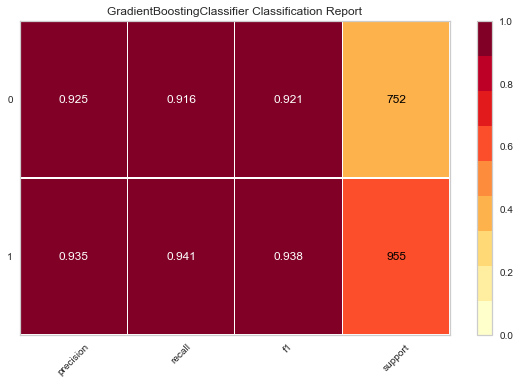

5-fold CV Scores:  [0.98294095 0.98044451 0.97944154 0.97755672 0.96980803]
Mean testing score:  0.9780383481848757
Mean training score:  0.981256406707063
Standard deviation:  0.004466860079091387


In [12]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(subsample=0.8, learning_rate=0.05 , n_estimators=160, random_state=5, max_depth=9, max_leaf_nodes=100)
gbc.fit(X_train, y_train)

y_predict_gbc = gbc.predict(X_test)

print(confusion_matrix(y_test, y_predict_gbc))
print(gbc.score(X_test,y_test))
display_score_results(gbc)

<h2>Naive bayes</h2>

[[773 182]
 [ 78 674]]
0.8476859988283538


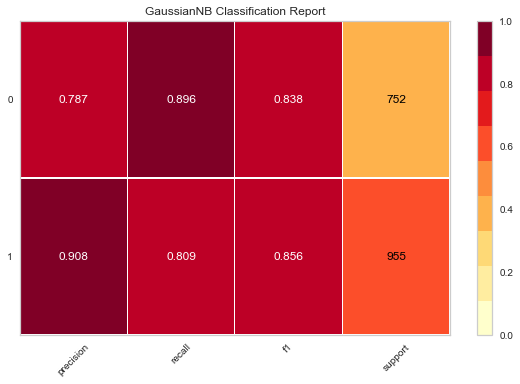

5-fold CV Scores:  [0.94996706 0.92881662 0.93773124 0.93986038 0.91944154]
Mean testing score:  0.9351633669660089
Mean training score:  0.9372517683074527
Standard deviation:  0.010346617996371554


In [13]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train,y_train)

y_predict_nb=nb.predict(X_test)

print(confusion_matrix(y_test, y_predict_nb))
print(nb.score(X_test,y_test))
display_score_results(nb)

For my Reference <br>
Precision: TP/TP+FP<br>
Recall: TP/TP+FN<br>
F1: 2 x (Recall x Precision)/(Recall + Precision)<br>
Support: total number actually in that class

It appears that the Support Vector Machine performed the best, just edging out Gradient Boosting. Either model would be an appropriate selection, but we will go with the SVM as it performed slightly better.